

## Data Description:-
There are 6 categorical features and 4 continuous features in the dataset. The label binary class.  

`survival` : Survival  
`pclass` : Ticket class  
`sex` : Sex  
`Age` : Age in years  
`sibsp` : # of siblings / spouses aboard the Titanic  
`parch` : # of parents / children aboard the Titanic  
`ticket` : Ticket number  
`fare` : Passenger fare  
`cabin` : Cabin number  
`embarked` : Port of Embarkation


In [5]:
# Asthetics
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# General
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os
from scipy.optimize import fmin as scip_fmin

# Visialisation
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

# Machine Learning

# Utils
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_validate
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn import preprocessing


#Feature Selection
from sklearn.feature_selection import chi2, f_classif, f_regression
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile, VarianceThreshold



In [6]:
RANDOM_SEED = 42

In [7]:
def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [8]:
seed_everything()

# Nulls Imputation
Let's have a basic look around the data we have at hand first

In [9]:
train_df = pd.read_csv('train.csv')


Let's see what columns we have in the training data.

In [10]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Looking at some sample rows...

In [11]:
train_df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
75721,75721,1,2,"Mason, Magdalena",female,57.0,0,0,SC/AH 453040,8.32,NaN,C
80184,80184,1,3,"Norton, Christopher",male,26.0,0,0,NaN,6.17,NaN,S
19864,19864,0,3,"Senske, Cecile",female,31.0,0,0,STON/O 359725,7.47,NaN,S
76699,76699,1,2,"Benfield, Lucia",female,41.0,0,0,37102,8.16,NaN,S
92991,92991,1,2,"Moore, Barbara",female,26.0,0,0,399820,61.50,NaN,S
76434,76434,0,2,"Wilson, Bobby",male,66.0,0,2,185037,31.89,NaN,S
84004,84004,1,1,"Wengerd, Freddie",female,45.0,1,0,22927,104.46,C18331,C
80917,80917,1,2,"Harris, Dorothy",female,51.0,1,1,24413,80.72,NaN,C
60767,60767,1,2,"Carter, Sheena",female,62.0,1,1,A/5. 12831,11.33,NaN,S
50074,50074,1,2,"Ward, Mary",female,46.0,0,1,338856,33.05,NaN,C


Let's look at some basic descriptive analysis...

In [12]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,100000.0,49999.500000,28867.657797,0.00,24999.75,49999.50,74999.25,99999.00
Survived,100000.0,0.427740,0.494753,0.00,0.00,0.00,1.00,1.00
Pclass,100000.0,2.106910,0.837727,1.00,1.00,2.00,3.00,3.00
Age,96708.0,38.355472,18.313556,0.08,25.00,39.00,53.00,87.00
SibSp,100000.0,0.397690,0.862566,0.00,0.00,0.00,1.00,8.00
Parch,100000.0,0.454560,0.950076,0.00,0.00,0.00,1.00,9.00
Fare,99866.0,43.929330,69.588820,0.68,10.04,24.46,33.50,744.66


In [13]:
train_df.nunique()

PassengerId    100000
Survived            2
Pclass              3
Name            92144
Sex                 2
Age               173
SibSp               7
Parch               8
Ticket          75331
Fare            15935
Cabin           26992
Embarked            3
dtype: int64

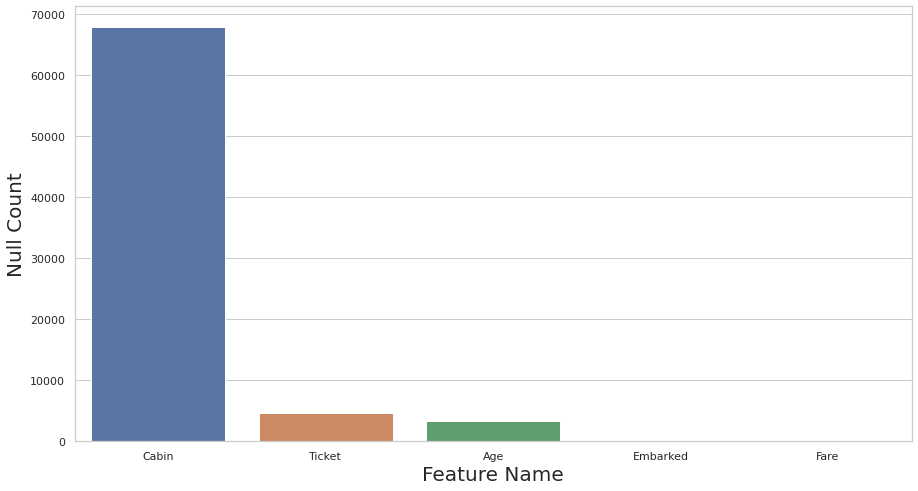

There are 5 features with missing values in the training data.
Columns containing nulls are: ['Cabin', 'Ticket', 'Age', 'Embarked', 'Fare']


In [14]:
nulls_train = np.sum(train_df.isnull())
nullcols_train = nulls_train.loc[(nulls_train != 0)].sort_values(ascending=False)

barplot_dim = (15, 8)
ax = plt.subplots(figsize=barplot_dim)
sns.barplot(x=nullcols_train.index, y=nullcols_train)
plt.ylabel("Null Count", size=20);
plt.xlabel("Feature Name", size=20);
plt.show()
print('There are', len(nullcols_train), 'features with missing values in the training data.')
print(f'Columns containing nulls are: {list(nullcols_train.index)}')

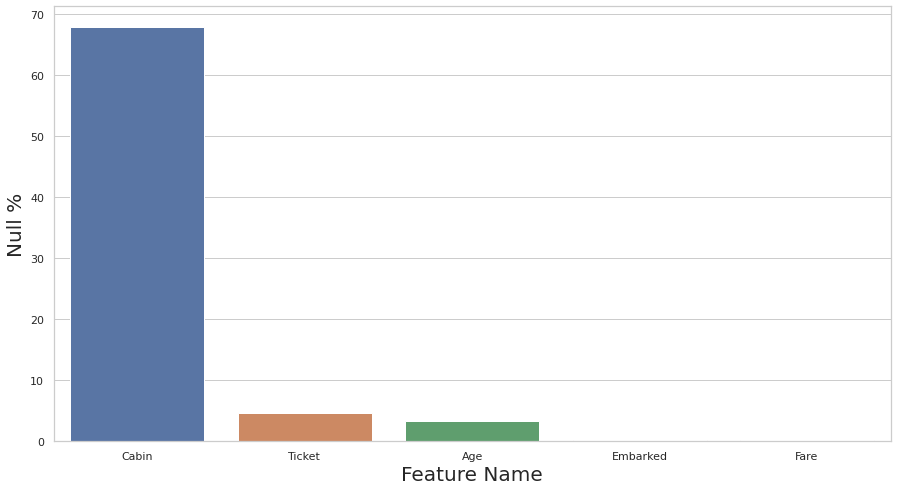

In [15]:
nulls_train = np.sum(train_df.isnull())
nullcols_train = nulls_train.loc[(nulls_train != 0)].sort_values(ascending=False)
nullcols_train = nullcols_train.apply(lambda x: 100*x/train_df.shape[0])

barplot_dim = (15, 8)
ax = plt.subplots(figsize=barplot_dim)
sns.barplot(x=nullcols_train.index, y=nullcols_train)
plt.ylabel("Null %", size=20);
plt.xlabel("Feature Name", size=20);
plt.show()

## 1. Cabin
We can see that the Cabin feature has quite a bit of missing values as compared to others (~ 68%).  


In [16]:
train_df['Cabin_Available'] = train_df['Cabin'].apply(lambda x: 0 if pd.isnull(x) else 1)


In [17]:
train_df['Cabin'].fillna('No Cabin', inplace=True)


## 2. Ticket
Around 5% of the values in ticket number is missing.  


In [18]:
train_df['Ticket_Available'] = train_df['Ticket'].apply(lambda x: 0 if pd.isnull(x) else 1)


In [19]:
train_df['Ticket'].fillna('Missing Ticket', inplace=True)


## 3. Age
Age is a continuous feature and almost 3% of those values are missing.  
.

In [20]:
train_df['Age_Available'] = train_df['Age'].apply(lambda x: 0 if pd.isnull(x) else 1)


In [21]:
train_df['Age'].fillna(train_df['Age'].mean(), inplace=True)


## 4. Embarked
Embarked is a categorical feature and almost 0.2% of the values are missing.  


In [22]:
train_df['Embarked_Available'] = train_df['Embarked'].apply(lambda x: 0 if pd.isnull(x) else 1)


In [23]:
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)


## 5. Fare
Fare is a continuos feature and close to 0.1% values are missing.  


In [24]:
train_df['Fare_Available'] = train_df['Fare'].apply(lambda x: 0 if pd.isnull(x) else 1)


In [25]:
train_df['Fare'] = train_df.groupby('Pclass').Fare.transform(lambda x: x.fillna(x.mean()))


Okay, now that we have addressed all the null columns, let's have a sanity check to ensure that we did not miss anything...

In [26]:
np.sum(train_df.isnull())

PassengerId           0
Survived              0
Pclass                0
Name                  0
Sex                   0
Age                   0
SibSp                 0
Parch                 0
Ticket                0
Fare                  0
Cabin                 0
Embarked              0
Cabin_Available       0
Ticket_Available      0
Age_Available         0
Embarked_Available    0
Fare_Available        0
dtype: int64

Great, it looks like we successfully managed to impute all the null values. Now moving on to EDA...

# EDA

## 1. Class Imbalance

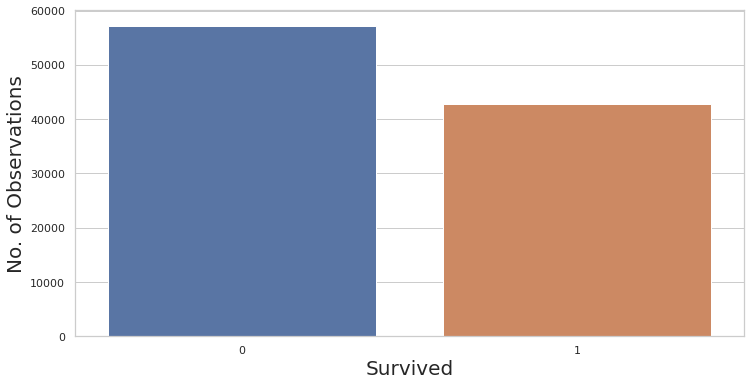

In [27]:
ax = plt.subplots(figsize=(12, 6))
sns.set_style("whitegrid")
sns.countplot(x='Survived', data=train_df);
plt.ylabel("No. of Observations", size=20);
plt.xlabel("Survived", size=20);

Ok, so this is a fairly balanced dataset. We have to keep this in mind while developing our models later.  
Now let's move on to understanding each individual feature through EDA and some visualizations... Before that l;et's create some helper functions that eases the EDA plotting process.

In [28]:
def plot_cat_distribution(cat, train_df=train_df):
    ax = plt.subplots(figsize=(12, 6))
    sns.set_style('whitegrid')
    sns.countplot(x=cat, data=train_df);
    plt.ylabel('No. of Observations', size=20);
    plt.xlabel(cat+' Count', size=20);
    plt.show()
    
def plot_cat_response(cat, train_df=train_df):
    ax = plt.subplots(figsize=(8, 5))
    sns.set_style('whitegrid')
    sns.countplot(x=cat, hue='Survived', data=train_df);
    plt.show()

## 2. PassengerID
The data description says it is an unique identifier for each row and does not hold any significant information regarding the passenger. Thus we can plan to drop this feature later while modelling.  

## 3. Pclass
This feature signifies the ticket class of the passenger. It is available as a categorical feature with 3 distinct values:- 1st Class, 2nd Class and 3rd Class. Let's look at their distribution and response towards Survival...

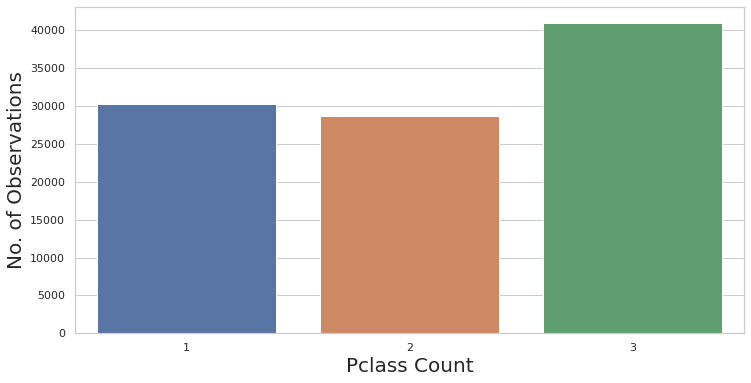

In [29]:
plot_cat_distribution('Pclass')

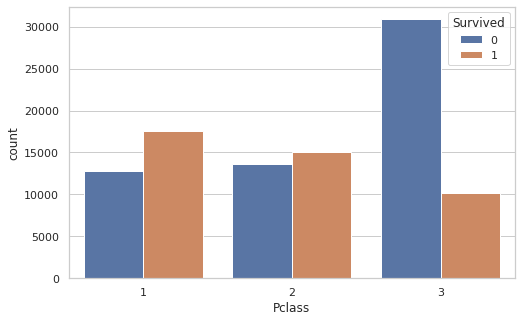

In [30]:
plot_cat_response('Pclass')

**Observations:-**  
* Maximum number of passengers were travelling on class 3 tickets.
* It seems that Class 1 and 2 passengers had a much higher chance of survival than Class 3 passengers.

## 4. Name
Name is again something which is most likely unique to the passenger and less/no effect on the probability of the survival of the person. Any correlation might be coincidental and not necessarily part of the signal. So we can drop this feature later.

## 5. Sex
As obvious as it is, this feature tells us the gender of the passangers. This one might be very significant because in case of evacuation weomen and children are given higher preference. Let's see if the data agrees...

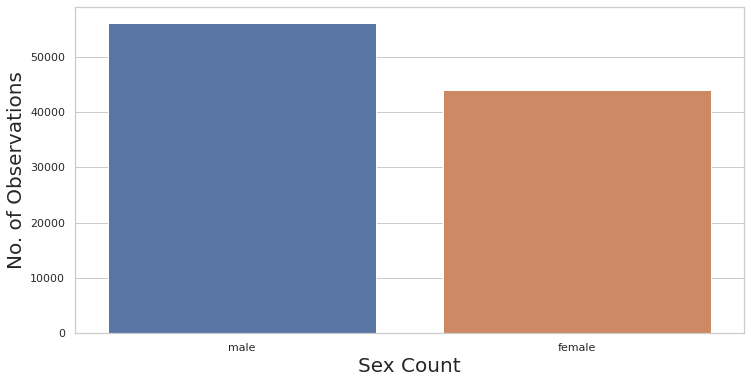

In [31]:
plot_cat_distribution('Sex')

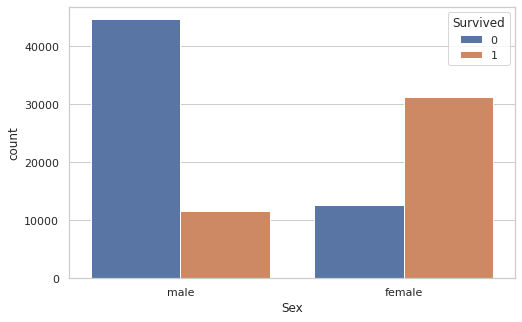

In [32]:
plot_cat_response('Sex')

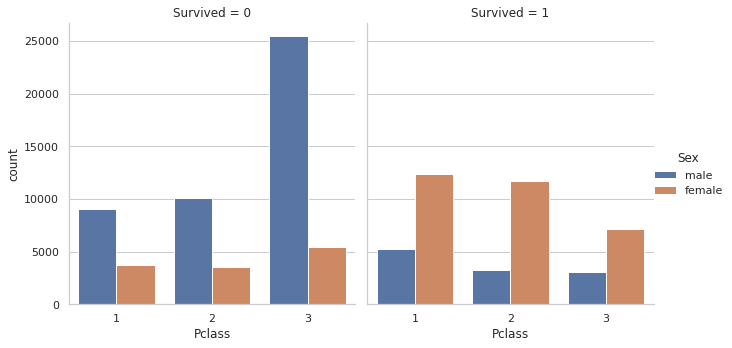

In [33]:
g = sns.catplot(x="Pclass", hue="Sex", col="Survived",
                data=train_df, kind="count");
g.fig.set_size_inches(10,5)

**Observation:-**  
* There were more male passengers on the ship ac comapred to females. But there is not a very high bias towards any specific gender.
* As expected, the probability of survival as a female is mugh higher as comapred to male passengers.
* Females from Class-1 had the highest chances of survival followed by Class-2 and then Class-3.

## 6. Age
Age is a continuous variable and one which can again be of high importance. Because in case of evacuation children and old people would be given preference. Let's check what the data says...

In [34]:
g = sns.displot(data=train_df, x="Age", hue="Survived", kind="kde");
g.fig.set_size_inches(10,5)

AttributeError: module 'seaborn' has no attribute 'displot'

There are more adults on the ship as compared to childeren

In [ ]:
g = sns.catplot(x='Survived', y='Age', kind='box', data=train_df);
g.fig.set_size_inches(10,5)

The average age of surviving passengers is more than deceased ones, stating that infact children and older people weere evacuated first from the ship. And just because the population of older people is larger than children, the average age is on the higher side.

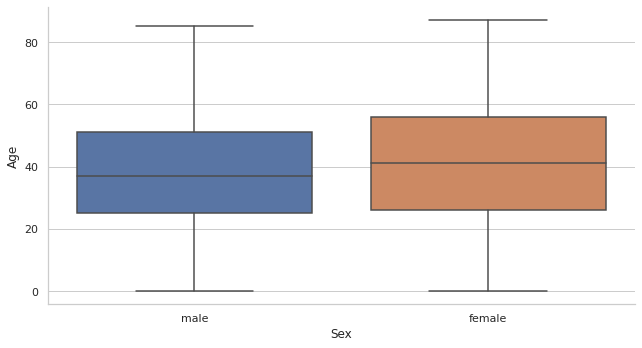

In [35]:
g = sns.catplot(x='Sex', y='Age', kind='box', data=train_df);
g.fig.set_size_inches(10,5)

On an average, the age of females on the boat was higher than males.

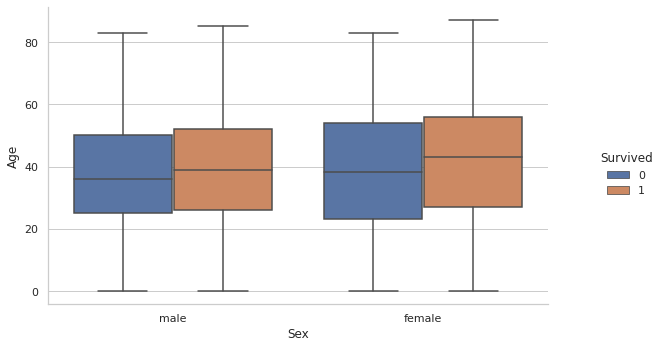

In [36]:
g = sns.catplot(x='Sex', y='Age', hue='Survived', kind='box', data=train_df);
g.fig.set_size_inches(10,5)

Older females had the highest chances of survival followed by older men.

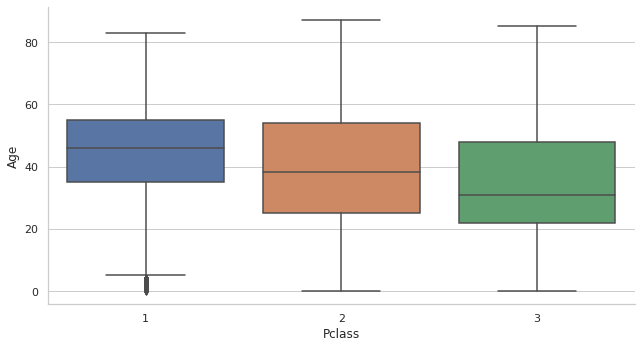

In [37]:
g = sns.catplot(x='Pclass', y='Age', kind='box', data=train_df);
g.fig.set_size_inches(10,5)

The average age in Class-1 is highest, followed by Class-2 and then Class-3.  
There are children in all 3 classes of the ship.  
Class-2 has the oldest preson, followed by Class-3 and then Class-1.

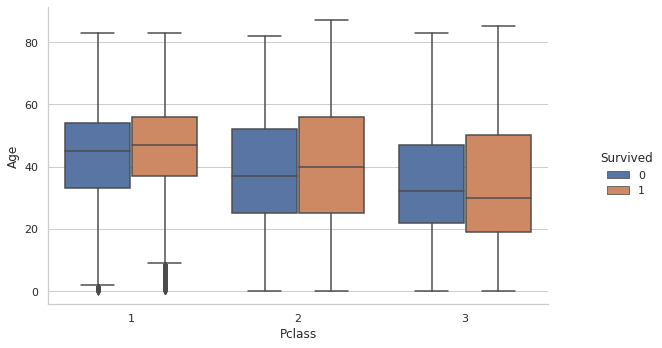

In [38]:
g = sns.catplot(x='Pclass', y='Age', hue='Survived', kind='box', data=train_df);
g.fig.set_size_inches(10,5)

**Observations:-**  
* There are more adults on the ship as compared to childeren.
* The average age of surviving passengers is more than deceased ones, stating that infact children and older people weere evacuated first from the ship. And just because the population of older people is larger than children, the average age is on the higher side.
* On an average, the age of females on the boat was higher than males.
* Older females had the highest chances of survival followed by older men.
* The average age in Class-1 is highest, followed by Class-2 and then Class-3.
* There are children in all 3 classes of the ship.
* Class-2 has the oldest preson, followed by Class-3 and then Class-1.
* Older people from Class-1 and Class-2 had better chances of survival as compared to their younger counterparts. But in Class-3, actually younger people had better chances of survival than older people.

## 7. SibSp
SibSp is a integer feature which specifies the number of siblings / spouses of the passenger aboard the Titanic. This might have an influence on survival because usually a human will also try to keep their relatives safe in case of a disaster.  
We can treat this a ordinal categorical features because there are only finite number of Siblings/Spouse a passenger could have aboard the ship.

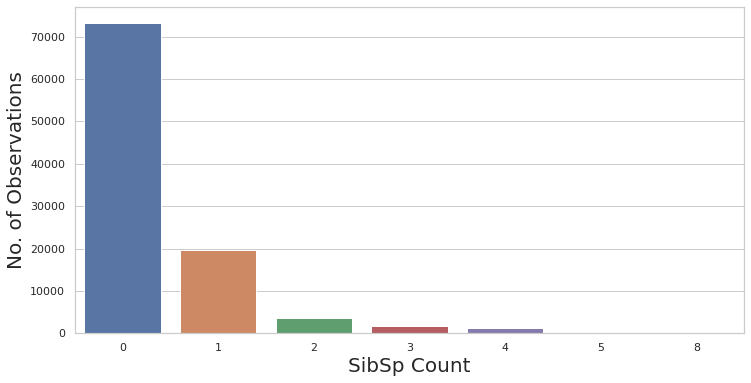

In [39]:
plot_cat_distribution('SibSp')

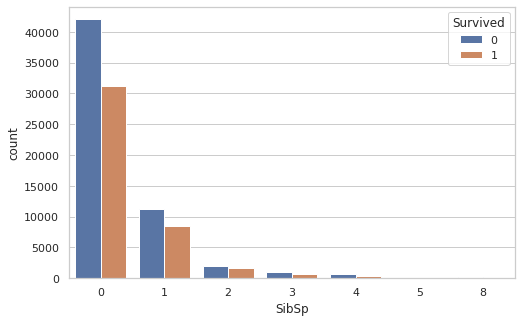

In [40]:
plot_cat_response('SibSp')

In [41]:
# Response Rate
v = train_df.groupby('SibSp').Survived.value_counts().unstack()
v['Ratio'] = v[1]/v[0]
v.reset_index(inplace=True)

In [42]:
v['Ratio'].mean()

0.6387080990607081

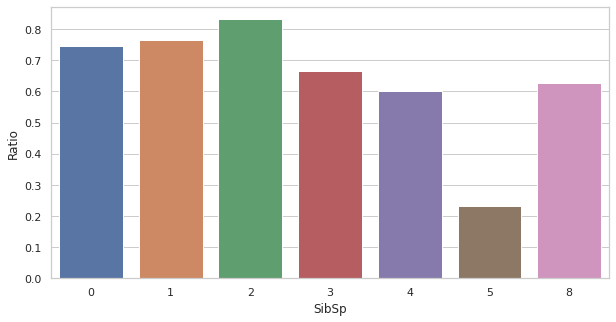

In [43]:
ax = plt.subplots(figsize=(10, 5))
sns.set_style("whitegrid")
sns.barplot(x='SibSp', y='Ratio', data=v.sort_values(by=['Ratio'], ascending=False));

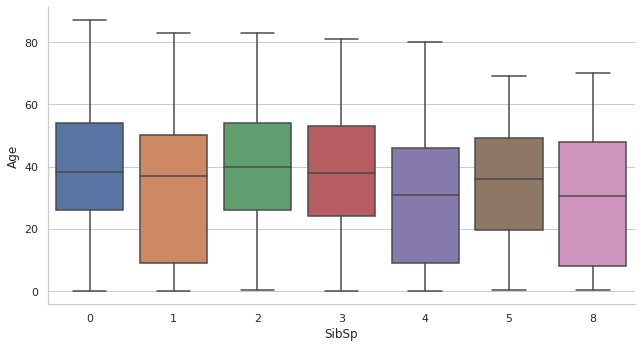

In [44]:
g = sns.catplot(x='SibSp', y='Age', kind='box', data=train_df);
g.fig.set_size_inches(10,5)

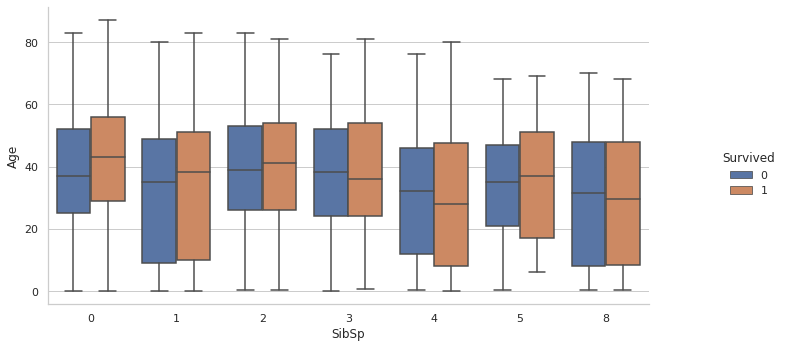

In [45]:
g = sns.catplot(x='SibSp', y='Age', hue='Survived', kind='box', data=train_df);
g.fig.set_size_inches(12,5)

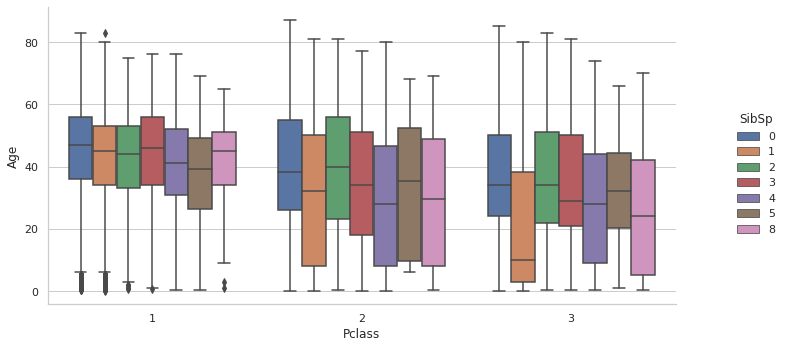

In [46]:
g = sns.catplot(x='Pclass', y='Age', hue='SibSp', kind='box', data=train_df);
g.fig.set_size_inches(12,5)

**Observations:-**  
* Most of the people were travelling without Siblings/Spouse.
* Survival rate of passengers having 2 Sibling/Spouse were the highest.
* Older and very young passengers were generally travelling without any Siblings/Spouse.
* Older people travelling with < 3 siblings/spouse had higher chances of survival.

## 8. Parch
Parch is a integer feature which specifies the number of parents / children of the passenger aboard the Titanic. This might have an influence on survival because usually any parent will try to keep their children safe in case of a disaster. Also while evacuating any children, a parent will be accompany them, so that also adds to the equation of survival...  
We can treat this a ordinal categorical features because there are only finite number of parents / children a passenger could have aboard the ship.

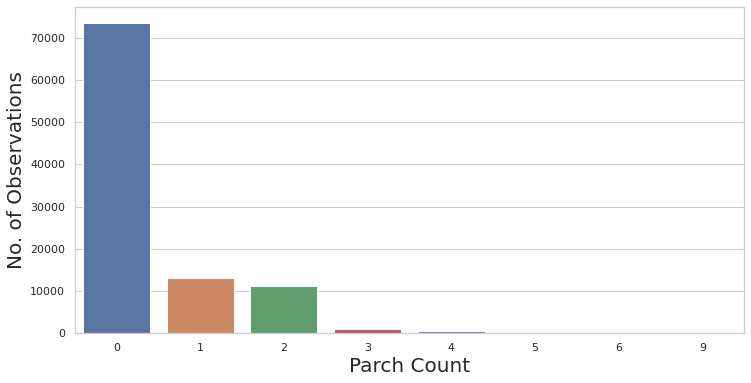

In [47]:
plot_cat_distribution('Parch')

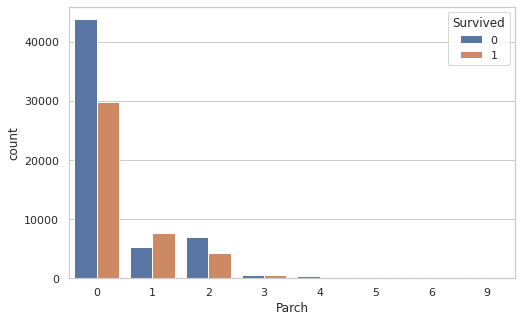

In [48]:
plot_cat_response('Parch')

In [49]:
# Response Rate
v = train_df.groupby('Parch').Survived.value_counts().unstack()
v['Ratio'] = v[1]/v[0]
v.reset_index(inplace=True)

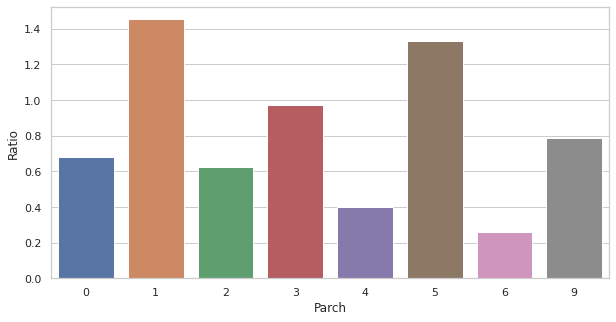

In [50]:
ax = plt.subplots(figsize=(10, 5))
sns.set_style("whitegrid")
sns.barplot(x='Parch', y='Ratio', data=v.sort_values(by=['Ratio'], ascending=False));

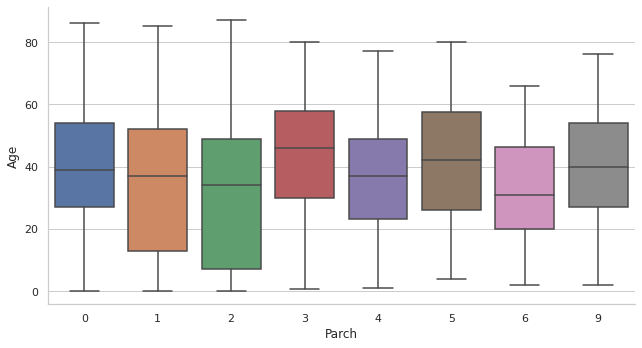

In [51]:
g = sns.catplot(x='Parch', y='Age', kind='box', data=train_df);
g.fig.set_size_inches(10,5)

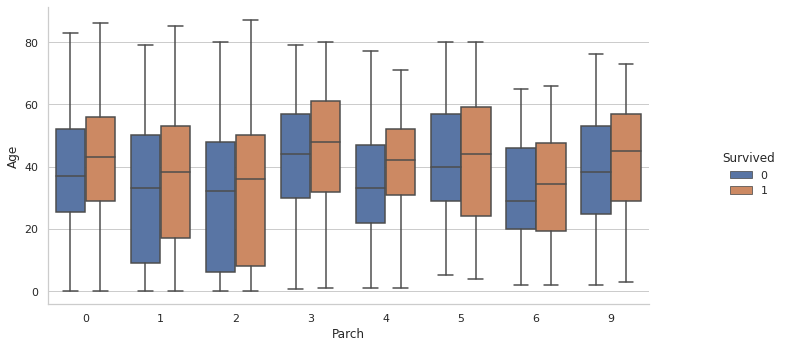

In [52]:
g = sns.catplot(x='Parch', y='Age', hue='Survived', kind='box', data=train_df);
g.fig.set_size_inches(12,5)

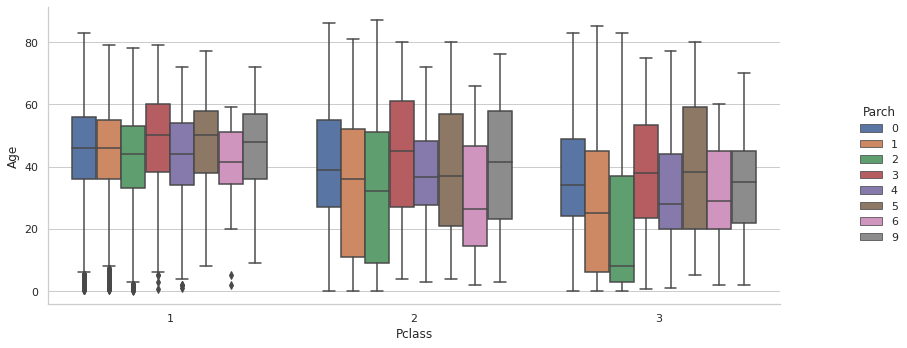

In [53]:
g = sns.catplot(x='Pclass', y='Age', hue='Parch', kind='box', data=train_df);
g.fig.set_size_inches(14,5)

**Observations:-**  
* Most passengers were travelling without any parents/children.
* Passengers having 1/3/5 parents/children are more likely to survive than others.
* Age has very little effect on the number of parents/children accompanying a passenger.

## 9. Fare
Fare is a continuous feature that specifies the total fare paid by the passenger for their place on the boat. It should be highly correlated with Class and total number of people on the same ticket.

In [54]:
g = sns.displot(data=train_df, x="Fare", hue="Survived", kind="kde");
g.fig.set_size_inches(10,5)

AttributeError: module 'seaborn' has no attribute 'displot'

The distribution has a very long tail, we probably need to tranform this while feature engineering.

In [ ]:
g = sns.catplot(x='Survived', y='Fare', kind='box', data=train_df);
g.fig.set_size_inches(10,5)

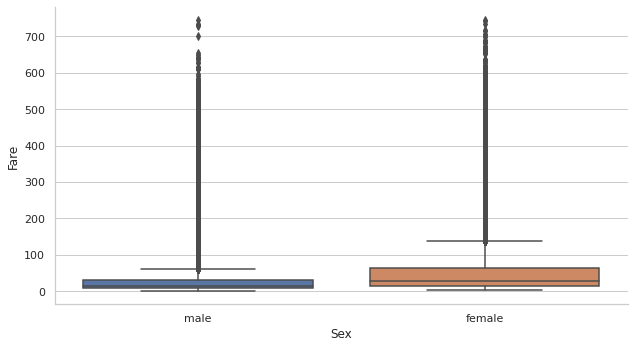

In [55]:
g = sns.catplot(x='Sex', y='Fare', kind='box', data=train_df);
g.fig.set_size_inches(10,5)

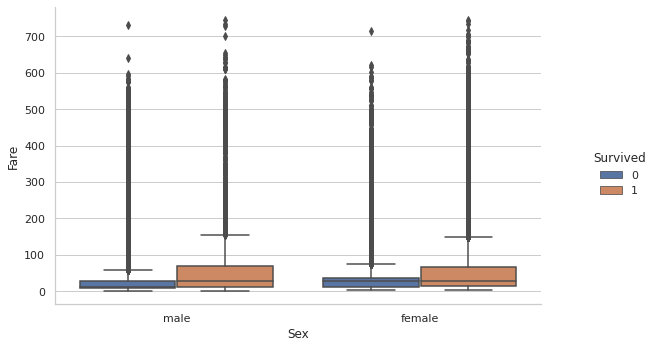

In [56]:
g = sns.catplot(x='Sex', y='Fare', hue='Survived', kind='box', data=train_df);
g.fig.set_size_inches(10,5)

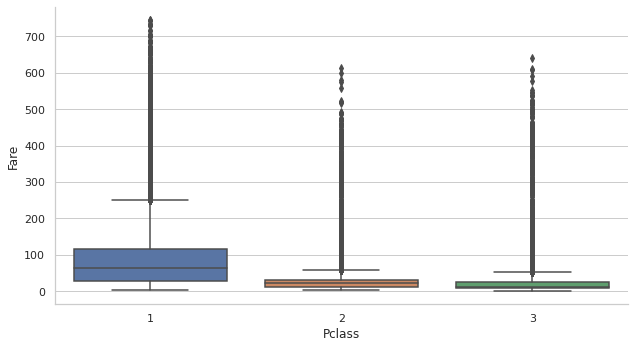

In [57]:
g = sns.catplot(x='Pclass', y='Fare', kind='box', data=train_df);
g.fig.set_size_inches(10,5)

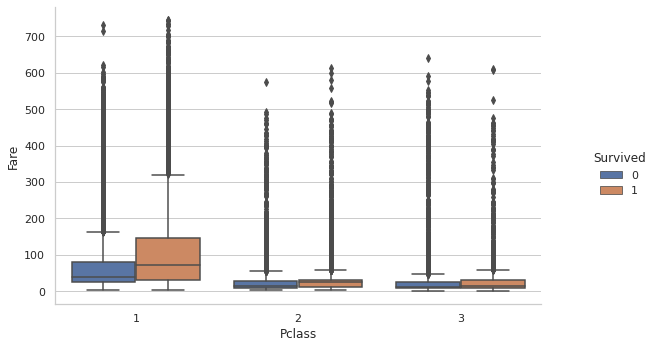

In [58]:
g = sns.catplot(x='Pclass', y='Fare', hue='Survived', kind='box', data=train_df);
g.fig.set_size_inches(10,5)

**Observations:-**  
* Probability distribution of Fare has a very long tail. Needs to be transformed during feature enginering.
* People who paid higher fare, also had a higher chance of survival.
* Average fare paid by Male passengers was lower than Female passengers.
* Higher fare males had a higher chance of survival than lower fare males. But in case of females there was not a big difference.
* Naturally, Class-1 had the highest fare followed by Class-2 and then Class-3.
* Higher fare peoples among Class-1 and Class-2 had higher chances of curvival as compared to their lower fare counterparts. However in Class-3, Fare did not matter much in terms of survival probability.

## 10. Embarked
This feature defines the port of Embarkation. We have 3 options in this category:- (C = Cherbourg, Q = Queenstown, S = Southampton).  
This feature might be important because it will also affect the order of filling of compartments. And due to compartment locations it might have an effect on the survival probability. This combined with Class would act like a spatial proxy for the location of the passenger inside the ship.

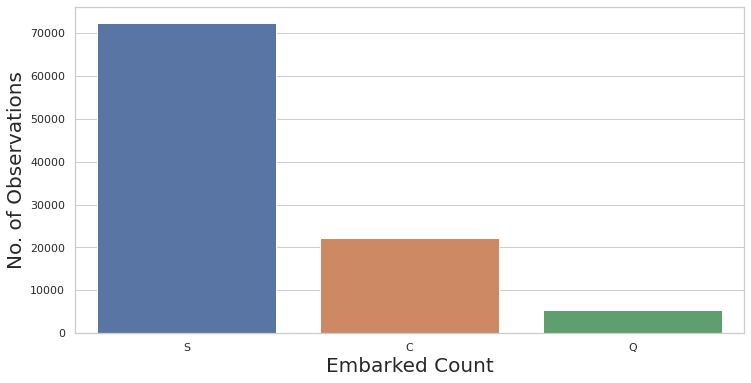

In [59]:
plot_cat_distribution('Embarked')

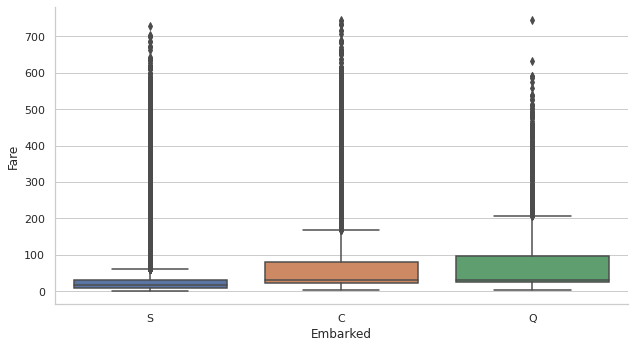

In [60]:
g = sns.catplot(x='Embarked', y='Fare', kind='box', data=train_df);
g.fig.set_size_inches(10,5)

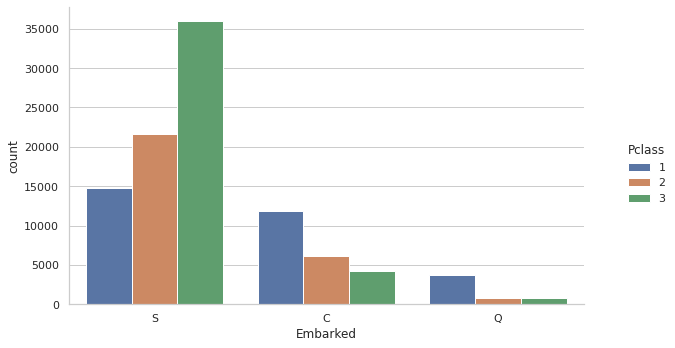

In [61]:
g = sns.catplot(x="Embarked", hue="Pclass",
                data=train_df, kind="count");
g.fig.set_size_inches(10,5)

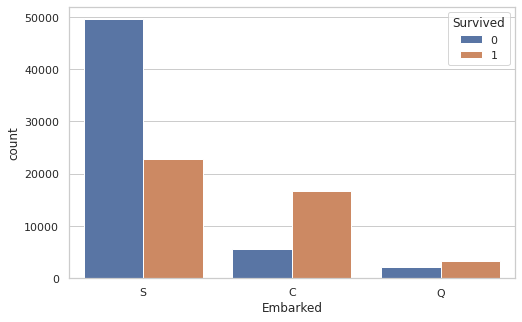

In [62]:
plot_cat_response('Embarked')

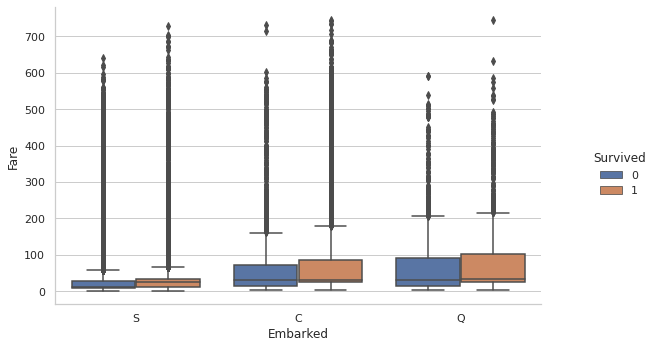

In [63]:
g = sns.catplot(x='Embarked', y='Fare', hue='Survived', kind='box', data=train_df);
g.fig.set_size_inches(10,5)

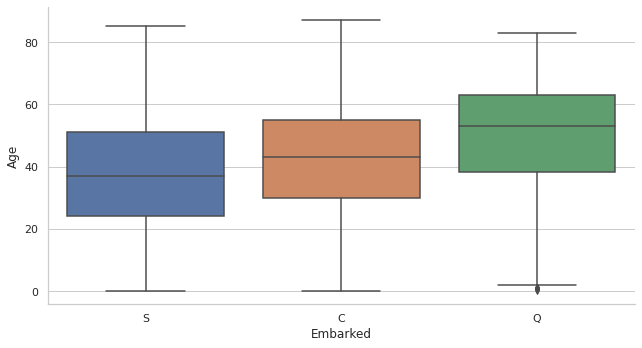

In [64]:
g = sns.catplot(x='Embarked', y='Age', kind='box', data=train_df);
g.fig.set_size_inches(10,5)

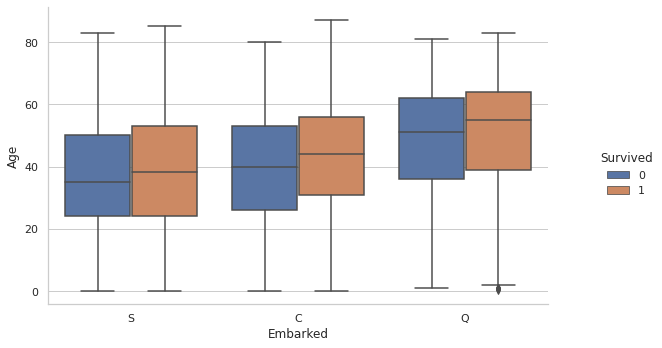

In [65]:
g = sns.catplot(x='Embarked', y='Age', hue='Survived', kind='box', data=train_df);
g.fig.set_size_inches(10,5)

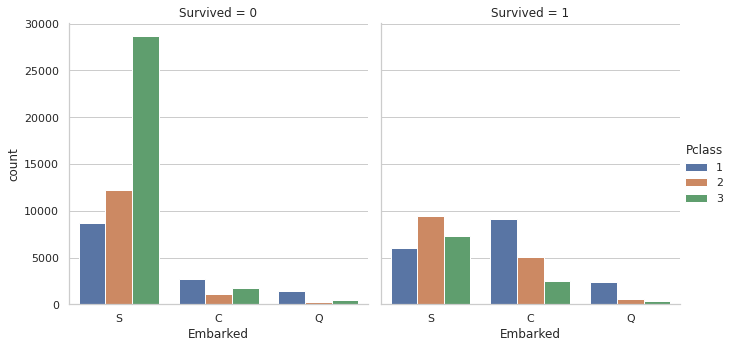

In [66]:
g = sns.catplot(x="Embarked", hue="Pclass", col="Survived",
                data=train_df, kind="count");
g.fig.set_size_inches(10,5)

**Observations:-**  
* Most of the passengers embarked the ship from Southampton.
* The average fare for people boarding from Southampton is lowest while Cherbourg and Queenstown are similar.
* As a result, most of the people bording from Southampton are Class-3 passengers while the majority of Cherbourg and Queenstown passengers belong to Class-1 or 2.
* Similarly, the survival probability of passengers from Cherbourg and Queenstown is higher as comapred to passengers from Southampton.
* People embarking from Southampton who paid a higher fare had a better chance of survival than people with lower fares. But the same can not be said about the people from Cherbourg and Queenstown.
* The Average age of people embarking from Southampton is lowest followed by Cherbourg and Queenstown.

